In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from IPython.display import display
from itertools import combinations
from collections import Counter
import numpy as np
from statsmodels.stats.multitest import multipletests
import os


In [2]:
#Functions for analysing:


def get_statistics_summary(df, columns_to_analyze, group_by_col="label_col", 
                         metrics=["mean", "std", "max"], sort_by=None, ascending=False):
    # Calculate statistics for all specified columns
    summary = df.groupby(group_by_col).agg({
        col: metrics for col in columns_to_analyze
    })
    
    # Flatten column names
    summary.columns = [f"{col[0]}_{col[1]}" for col in summary.columns]
    
    # Sort if specified
    if sort_by is not None:
        summary = summary.sort_values(sort_by, ascending=ascending)
    
    return summary

def count_partial_combinations(df, min_features=2, max_features=None):
    # Set max_features to the length of the largest combination if not specified
    if max_features is None:
        max_features = max(len(features) for features in df["features"])
    
    # Counter for partial combinations
    combination_counts = Counter()

    # Iterate over all rows in the DataFrame
    for feature_list in df["features"]:
        # Generate all possible subsets (partial combinations)
        for r in range(min_features, max_features + 1):
            for subset in combinations(sorted(feature_list), r):  # Sort to ensure order invariance
                combination_counts[subset] += 1

    # Convert the Counter to a DataFrame for better visualization
    results_df = pd.DataFrame.from_dict(combination_counts, orient="index", columns=["count"])
    results_df.index = results_df.index.map(lambda x: "+".join(x))  # Convert tuples to strings
    results_df = results_df.sort_values("count", ascending=False)
    
    return results_df
def pretraining_featureextraction_analysis(df):
    #Pretraining Analyses
    pretrained_summary = df.groupby("Pretraining_applied")["Balanced_ACC"].mean()
    display(pretrained_summary)

    pretrained_data = df[df["Pretraining_applied"]==True]["Balanced_ACC"]
    non_pretrained_data = df[df["Pretraining_applied"]==False]["Balanced_ACC"]
    t_stat, p_val = ttest_ind(pretrained_data, non_pretrained_data)
    print("T-test Pretrained vs Non-pretrained:", t_stat, p_val)

    #Feature extraction analyses
    feature_extraction_summary = df.groupby("Feature_extraction_applied")["Balanced_ACC"].mean()
    display(feature_extraction_summary)

    feature_extraction_data = df[df["Feature_extraction_applied"]==True]["Balanced_ACC"]
    non_feature_extraction_data = df[df["Feature_extraction_applied"]==False]["Balanced_ACC"]
    t_stat, p_val = ttest_ind(feature_extraction_data, non_feature_extraction_data)
    print("T-test Feature extraction vs Non-feature extraction:", t_stat, p_val)

def feature_statistical_testing_easy(df, metric_column="mean"):
    # Get a unique list of features
    all_features = set(f for feature_list in df["features"] for f in feature_list)
    for feature in all_features:
        df[feature] = df["features"].apply(lambda x: 1 if feature in x else 0)
    
    # Perform statistical testing
    results = {}
    for feature in all_features:
        group_with_feature = df[df[feature] == 1][metric_column]
        group_without_feature = df[df[feature] == 0][metric_column]
        t_stat, p_value = ttest_ind(group_with_feature, group_without_feature, equal_var=False)
        results[feature] = {"t-statistic": t_stat, "p-value": p_value}
    
    # Convert results to a DataFrame for better visualization
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values("p-value")
    display(results_df)
    return results_df

def feature_statistical_testing(df, metric_column="mean", alpha=0.05, correction_method='fdr_bh'):
    """
    Perform statistical testing for feature significance using independent t-tests
    with multiple testing correction.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing a 'features' column with lists of features and a metric column
    metric_column : str, default="mean"
        Name of the column containing the metric to test
    alpha : float, default=0.05
        Significance level for hypothesis testing
    correction_method : str, default='fdr_bh'
        Multiple testing correction method ('fdr_bh', 'bonferroni', etc.)
        
    Returns:
    --------
    pandas.DataFrame
        Results containing t-statistics, p-values, and adjusted p-values
    """
    # Input validation
    if "features" not in df.columns:
        raise ValueError("DataFrame must contain a 'features' column")
    if metric_column not in df.columns:
        raise ValueError(f"DataFrame must contain the metric column: {metric_column}")
    
    # Get unique features
    all_features = set(f for feature_list in df["features"] for f in feature_list)
    
    # Create binary columns for each feature
    feature_columns = {}
    for feature in all_features:
        feature_columns[feature] = df["features"].apply(lambda x: 1 if feature in x else 0)
    
    # Add binary columns to DataFrame
    feature_df = pd.DataFrame(feature_columns)
    df = pd.concat([df, feature_df], axis=1)
    
    # Perform statistical testing
    results = {}
    p_values = []
    
    for feature in all_features:
        # Get groups
        group_with_feature = df[df[feature] == 1][metric_column]
        group_without_feature = df[df[feature] == 0][metric_column]
        
        # Skip if either group is empty
        if len(group_with_feature) == 0 or len(group_without_feature) == 0:
            results[feature] = {
                "t-statistic": np.nan,
                "p-value": np.nan,
                "mean_with_feature": np.nan,
                "mean_without_feature": np.nan,
                "sample_size_with": len(group_with_feature),
                "sample_size_without": len(group_without_feature)
            }
            p_values.append(np.nan)
            continue
            
        # Calculate t-test
    try:
        t_stat, p_value = ttest_ind(
            group_with_feature,
            group_without_feature,
            equal_var=False,  # Using Welch's t-test
            nan_policy='omit'
        )
    except Exception as e:
        print(f"Error with feature: {feature}")
        # Store results
        results[feature] = {
            "t-statistic": t_stat,
            "p-value": p_value,
            "mean_with_feature": group_with_feature.mean(),
            "mean_without_feature": group_without_feature.mean(),
            "sample_size_with": len(group_with_feature),
            "sample_size_without": len(group_without_feature)
        }
        p_values.append(p_value)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T
    
    # Apply multiple testing correction
    valid_p_values = ~np.isnan(p_values)
    if sum(valid_p_values) > 0:
        _, adjusted_p_values, _, _ = multipletests(
            p_values[valid_p_values],
            alpha=alpha,
            method=correction_method
        )
        
        # Add adjusted p-values back to results
        results_df['adjusted_p_value'] = np.nan
        results_df.loc[valid_p_values, 'adjusted_p_value'] = adjusted_p_values
    
    # Sort by adjusted p-value, then regular p-value
    results_df = results_df.sort_values(
        ['adjusted_p_value', 'p-value'],
        na_position='last'
    )
    
    return results_df
    

def full_analyses(df, show_whole_df_at_start=False, feature_extraction_analyses=True, tag=""):
    print("#"*10)
    print("Full analyses")
    print("#"*10)
    print("\n Sorted by best model\n")
    if show_whole_df_at_start:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            display(df.sort_values("Balanced_ACC", ascending=False))
    else:
        display(df.sort_values("Balanced_ACC", ascending=False))

    print("\nValue counts for label column\n")
    display(df["label_col"].value_counts())

    print("\nMean and std for Balanced_ACC\n")
    overall_mean = df["Balanced_ACC"].mean()
    overall_std = df["Balanced_ACC"].std()
    overall_permutated_mean = df["Permutation_Balanced_ACC"].mean()
    overall_permutated_std = df["Permutation_Balanced_ACC"].std()

    display(f"Overall mean: {overall_mean}, std: {overall_std}")
    display(f"Overall permuted mean: {overall_permutated_mean}, std: {overall_permutated_std}")
    display(f"Mean difference: {overall_mean-overall_permutated_mean}, std difference: {overall_std-overall_permutated_std}")
    df["Balanced_ACC"].hist()
    plt.title("Balanced Accuracy Distribution")
    plt.show()
    df["Permutation_Balanced_ACC"].hist()
    plt.title("Permutation Balanced Accuracy Distribution")
    plt.show()

    summary = get_statistics_summary(df, ["Balanced_ACC", "Permutation_Balanced_ACC"], sort_by="Balanced_ACC_mean", ascending=False)
    summary.plot(kind="bar", y="Balanced_ACC_mean", yerr="Balanced_ACC_std", title="Balanced Accuracy by Label")
    plt.title("Balanced Accuracy by Label")
    plt.show()
    print(f"Sorted by mean {tag}")
    display(summary)
    print("Sorted by max")
    display(summary.sort_values("Balanced_ACC_max", ascending=False))

    
    print("\nMean and std for Balanced_ACC by mri_table\n")
    print("NOT FILTERED FOR FEATURE EXTRACTION")
    summary = get_statistics_summary(df, ["Balanced_ACC", "Permutation_Balanced_ACC"], group_by_col="mri_table", sort_by="Balanced_ACC_mean", ascending=False)
    summary.plot(kind="bar", y="Balanced_ACC_mean", yerr="Balanced_ACC_std", title="Balanced Accuracy by MRI Table")
    plt.show()
    print(f"Sorted by mean {tag}")
    display(summary)
    print("Sorted by max")
    display(summary.sort_values("Balanced_ACC_max", ascending=False))

    summary["features"] = summary.index.str.split('_')
    top_n = 10
    top_features = summary.nlargest(top_n, 'Balanced_ACC_mean')["features"].explode().value_counts()
    print("Feature Importance by Count:")
    display(top_features)
    if feature_extraction_analyses:
        print("FILTERED FOR FEATURE EXTRACTION - NO FEATURE EXTRACTION APPLIED")
        df_filterd_for_no_feature_extraction = df[df["Feature_extraction_applied"]==False]
        mri_table_summary_filtered = get_statistics_summary(df_filterd_for_no_feature_extraction, ["Balanced_ACC", "Permutation_Balanced_ACC"], group_by_col="mri_table", sort_by="Balanced_ACC_mean", ascending=False)
        mri_table_summary_filtered.plot(kind="bar", y="Balanced_ACC_mean", yerr="Balanced_ACC_std", title="Balanced Accuracy by MRI Table - No FE")
        plt.show()
        print(f"Sorted by mean {tag}")
        display(mri_table_summary_filtered)
        print("Sorted by max")
        display(mri_table_summary_filtered.sort_values("Balanced_ACC_max", ascending=False))

        mri_table_summary_filtered["features"] = mri_table_summary_filtered.index.str.split('_')
        top_n = 10
        top_features = mri_table_summary_filtered.nlargest(top_n, 'Balanced_ACC_mean')["features"].explode().value_counts()
        print("Feature Importance by Count:")
        display(top_features)
        #feature_statistical_testing(mri_table_summary_filtered)
        print("Combination counts for features")
        combination_counts = count_partial_combinations(mri_table_summary_filtered.nlargest(top_n, 'Balanced_ACC_mean')[["Balanced_ACC_mean", "features"]])
        display(combination_counts)

        print("FILTERED FOR FEATURE EXTRACTION - FEATURE EXTRACTION APPLIED")
        df_filterd_for_feature_extraction = df[df["Feature_extraction_applied"]==True]
        mri_table_summary_filtered = get_statistics_summary(df_filterd_for_feature_extraction, ["Balanced_ACC", "Permutation_Balanced_ACC"], group_by_col="mri_table", sort_by="Balanced_ACC_mean", ascending=False)
        mri_table_summary_filtered.plot(kind="bar", y="Balanced_ACC_mean", yerr="Balanced_ACC_std", title="Balanced Accuracy by MRI Table - FE")
        mri_table_summary_filtered["features"] = mri_table_summary_filtered.index.str.split('_')
        top_n = 10
        top_features = mri_table_summary_filtered.nlargest(top_n, 'Balanced_ACC_mean')["features"].explode().value_counts()
        print("Feature Importance by Count:")
        display(top_features)
        #feature_statistical_testing(mri_table_summary_filtered)
    print("\nMean and std for Balanced_ACC by model type\n")
    summary = get_statistics_summary(df, ["Balanced_ACC", "Permutation_Balanced_ACC"], group_by_col="model_type", sort_by="Balanced_ACC_mean", ascending=False)
    summary.plot(kind="bar", y="Balanced_ACC_mean", yerr="Balanced_ACC_std", title="Balanced Accuracy by Model Type")
    plt.show()
    print(f"Sorted by mean {tag}")
    display(summary)
    print("Sorted by max")
    display(summary.sort_values("Balanced_ACC_max", ascending=False))

    if feature_extraction_analyses:
        print("\nPretraing and Feature Extraction analyses")
        pretraining_featureextraction_analysis(df)
        
        print("\nPretraining and Finetuning analyses for DL Models\n")
        df_deeplearning = df[~df["model_type"].isin(["Logistic Regression", "Random Forest"])]
        pretraining_featureextraction_analysis(df_deeplearning)

In [3]:
#df = pd.read_csv('/home/esralenz/Dokumente/20_HITKIP/03_UKB/00_Git_Code/UK-B-CLIP/08_analyse_results/2025_01_12_14_08_43.csv')
#df_raw = pd.read_csv('training_log_raw.csv')

In [4]:
#df_raw.sort_values("Balanced_ACC", ascending=False).head(20)
#if the number of pos < 350 drop the row
#df_raw_filterd = df_raw[df_raw["number_of_pos"]>350]
#df_raw_filterd.sort_values("Balanced_ACC", ascending=False).head(50)


In [5]:
#concatenate all df in the df csvs_deconfounded chekc if teh end on .csv
path = "00_results/tabpfn_age/"
csvs_deconfounded = [path + f for f in os.listdir(path) if f.endswith('.csv')]
df = pd.concat([pd.read_csv(file) for file in csvs_deconfounded])

In [6]:
#df = pd.read_csv("/home/esralenz/Dokumente/20_HITKIP/03_UKB/00_Git_Code/UK-B-CLIP/08_analyse_results/CNN_schaefer/CNN_Schäfer21_01.csv")

In [7]:
df["mri_table"] = (
    df["mri_table"]
    .str.replace("FC_100", "FC.100", regex=False)
    .str.replace("FC_25", "FC.25", regex=False)
    .str.replace("grey_matter", "grey.matter", regex=False)
    .str.replace(".csv", "", regex=False)
)

In [8]:
df["mri_table"].unique()

array(['aseg.volume_aparc.volume_aparc.thickness'], dtype=object)

In [9]:
#concatenate the two dataframes
#df = pd.concat([df, df_raw_filterd])

In [10]:
df["model_type"].unique()

array(['TabPFN', 'LGBM', 'Random', 'MLP', 'CNN'], dtype=object)

In [11]:
df["label_col"].unique()

array(['label_age_group'], dtype=object)

In [12]:
df

,label_col,mri_table,test_set_size,Feature_extraction_applied,Pretraining_applied,model_type,Accuracy,AUC,Balanced_ACC,Permutation_Balanced_ACC,number_of_cross_validations,cross_validation_count,search_term,percentage_of_data,eval_or_train
0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False,False,TabPFN,0.500000,0.729464,0.362500,0.358135,5,0,0.01_BE_TabPFN_train,0.01,train
1,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False,False,TabPFN,0.290000,0.630685,0.397362,0.298591,5,0,0.01_BE_TabPFN_eval,0.01,eval
2,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False,False,TabPFN,0.541667,0.760552,0.418750,0.220238,5,1,0.01_BE_TabPFN_train,0.01,train
3,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False,False,TabPFN,0.307500,0.625037,0.436401,0.343490,5,1,0.01_BE_TabPFN_eval,0.01,eval
4,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False,False,TabPFN,0.416667,0.748781,0.350694,0.216667,5,2,0.01_BE_TabPFN_train,0.01,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False,False,CNN,0.312500,0.635650,0.418813,0.331003,5,2,0.1_Nothing_CNN_eval,0.10,eval
246,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False,False,CNN,0.519608,0.734558,0.433134,0.260973,5,3,0.1_Nothing_CNN_train,0.10,train
247,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False,False,CNN,0.297500,0.625063,0.401359,0.272992,5,3,0.1_Nothing_CNN_eval,0.10,eval
248,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False,False,CNN,0.500000,0.744014,0.418980,0.251997,5,4,0.1_Nothing_CNN_train,0.10,train


In [13]:
mean_metrics_with_others_df_1 = df.groupby(
    ['search_term'], as_index=False
).agg({
    'Accuracy': 'mean',
    'AUC': 'mean',
    'Balanced_ACC': 'mean',
    'Permutation_Balanced_ACC': 'mean',
    'cross_validation_count': 'mean',
    # Keeping the first instance of other columns
    'label_col': 'first',
    'mri_table': 'first',
    'test_set_size': 'first',
    'Pretraining_applied': 'first',
})

In [15]:
mean_metrics_with_others_df_1.sort_values("Balanced_ACC", ascending=False)

,search_term,Accuracy,AUC,Balanced_ACC,Permutation_Balanced_ACC,cross_validation_count,label_col,mri_table,test_set_size,Pretraining_applied
55,0.1_BE_MLP_train,0.548039,0.777710,0.503036,0.250264,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False
85,0.1_Nothing_MLP_train,0.540196,0.766534,0.493223,0.247132,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False
95,0.1_PCA_MLP_train,0.547059,0.753216,0.483071,0.257330,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False
89,0.1_Nothing_TabPFN_train,0.590196,0.826994,0.477957,0.253839,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False
83,0.1_Nothing_LGBM_train,0.590196,0.782276,0.477909,0.265562,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False
...,...,...,...,...,...,...,...,...,...,...
26,0.01_Correlation_with_target_Random_eval,0.266667,0.540057,0.237917,0.260774,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False
6,0.01_BE_Random_eval,0.275000,0.569466,0.232778,0.248155,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False
7,0.01_BE_Random_train,0.275000,0.569466,0.232778,0.248155,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False
46,0.01_PCA_Random_eval,0.241667,0.505791,0.232500,0.345952,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False


In [16]:
mean_metrics_with_others_df = df.groupby(
    ['search_term', 'model_type'], as_index=False
).agg({
    'Accuracy': 'mean',
    'AUC': 'mean',
    'Balanced_ACC': 'mean',
    'Permutation_Balanced_ACC': 'mean',
    'cross_validation_count': 'mean',
    # Keeping the first instance of other columns
    'label_col': 'first',
    'mri_table': 'first',
    'test_set_size': 'first',
    'Pretraining_applied': 'first',
})
#make the label col fisrt column
target_col = 'label_col'
columns = [target_col] + [col for col in mean_metrics_with_others_df if col != target_col]
mean_metrics_with_others_df = mean_metrics_with_others_df[columns]
df = mean_metrics_with_others_df_1

In [17]:
print(df["label_col"].value_counts())

label_col
label_age_group    100
Name: count, dtype: int64


In [18]:
#get all labels that have sex_column in there
df[df["label_col"].str.contains("sex_balanced")]["label_col"].unique()

array([], dtype=object)

In [20]:
df.groupby("mri_table")["Balanced_ACC"].agg(["mean", "max"]).sort_values("mean", ascending=False)


,mean,max
mri_table,,
aseg.volume_aparc.volume_aparc.thickness,0.367148,0.503036


##########
Full analyses
##########

 Sorted by best model



,search_term,Accuracy,AUC,Balanced_ACC,Permutation_Balanced_ACC,cross_validation_count,label_col,mri_table,test_set_size,Pretraining_applied,tag
55,0.1_BE_MLP_train,0.548039,0.777710,0.503036,0.250264,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False,other
85,0.1_Nothing_MLP_train,0.540196,0.766534,0.493223,0.247132,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False,other
95,0.1_PCA_MLP_train,0.547059,0.753216,0.483071,0.257330,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False,other
89,0.1_Nothing_TabPFN_train,0.590196,0.826994,0.477957,0.253839,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False,other
83,0.1_Nothing_LGBM_train,0.590196,0.782276,0.477909,0.265562,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,90.00% (approx. of data left for test),False,other
...,...,...,...,...,...,...,...,...,...,...,...
26,0.01_Correlation_with_target_Random_eval,0.266667,0.540057,0.237917,0.260774,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False,other
6,0.01_BE_Random_eval,0.275000,0.569466,0.232778,0.248155,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False,other
7,0.01_BE_Random_train,0.275000,0.569466,0.232778,0.248155,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False,other
46,0.01_PCA_Random_eval,0.241667,0.505791,0.232500,0.345952,2.0,label_age_group,aseg.volume_aparc.volume_aparc.thickness,99.00% (approx. of data left for test),False,other



Value counts for label column



label_col
label_age_group    100
Name: count, dtype: int64


Mean and std for Balanced_ACC



'Overall mean: 0.3671476046713974, std: 0.07677407135817697'

'Overall permuted mean: 0.2850844718136937, std: 0.04185012987550674'

'Mean difference: 0.08206313285770372, std difference: 0.03492394148267023'

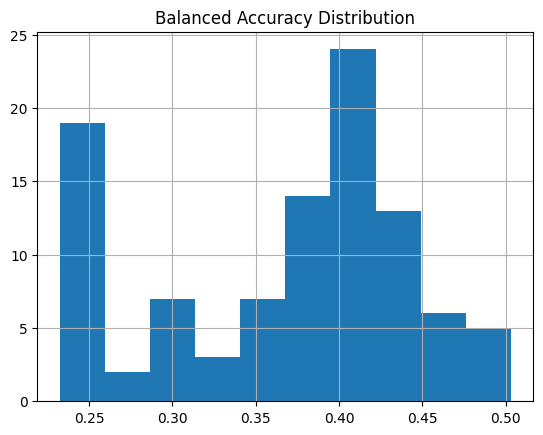

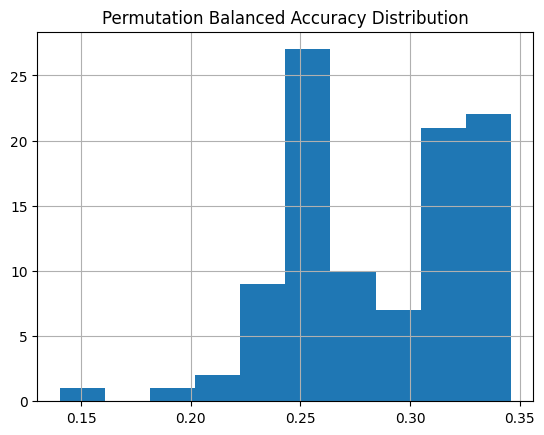

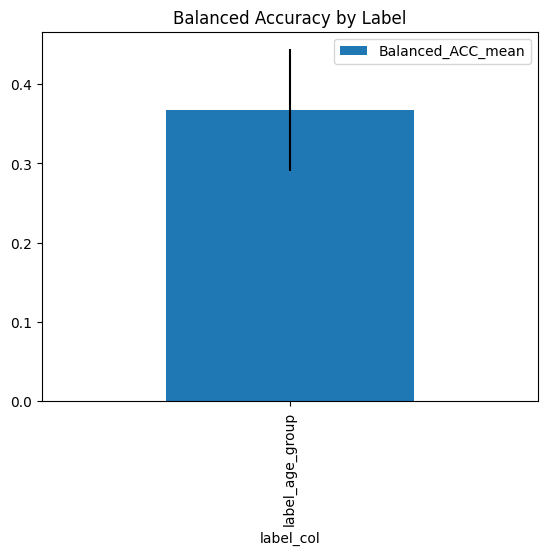

Sorted by mean 


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
label_col,,,,,,
label_age_group,0.367148,0.076774,0.503036,0.285084,0.04185,0.345952


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
label_col,,,,,,
label_age_group,0.367148,0.076774,0.503036,0.285084,0.04185,0.345952



Mean and std for Balanced_ACC by mri_table

NOT FILTERED FOR FEATURE EXTRACTION


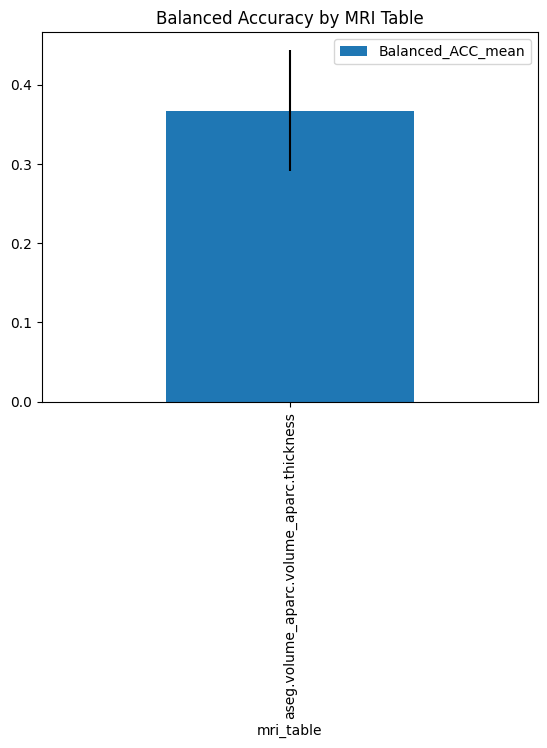

Sorted by mean 


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aseg.volume_aparc.volume_aparc.thickness,0.367148,0.076774,0.503036,0.285084,0.04185,0.345952


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aseg.volume_aparc.volume_aparc.thickness,0.367148,0.076774,0.503036,0.285084,0.04185,0.345952


Feature Importance by Count:


features
aseg.volume        1
aparc.volume       1
aparc.thickness    1
Name: count, dtype: int64

FILTERED FOR FEATURE EXTRACTION - NO FEATURE EXTRACTION APPLIED


KeyError: 'Feature_extraction_applied'

In [21]:
#Do the full analyses for the different tags
full_analyses(df)

------------------------------

Analyses for tag: Depression
##########
Full analyses
##########

 Sorted by best model



,search_term,model_type,Feature_extraction_applied,Accuracy,AUC,Balanced_ACC,Permutation_Balanced_ACC,cross_validation_count,label_col,mri_table,number_of_pos,number_of_neg,test_set_size,y_label_ratio,sex_label_ratio,Pretraining_applied,tag
43,label_doub_dep_sex_balanced_aparc.volume_aseg....,Random Forest,True,0.574194,0.574194,0.574194,0.503701,2.0,label_doub_dep_sex_balanced,aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
16,label_doub_dep_sex_balanced_aparc.thickness_ap...,CatBoost,False,0.570968,0.570968,0.570968,0.454739,2.0,label_doub_dep_sex_balanced,aparc.thickness_aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
40,label_doub_dep_sex_balanced_aparc.volume_aseg....,CatBoost,False,0.567742,0.567742,0.567742,0.461153,2.0,label_doub_dep_sex_balanced,aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
45,label_doub_dep_sex_balanced_aparc.volume_aseg....,TabPFN,True,0.559677,0.559677,0.559677,0.530553,2.0,label_doub_dep_sex_balanced,aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
41,label_doub_dep_sex_balanced_aparc.volume_aseg....,CatBoost,True,0.554839,0.554839,0.554839,0.532234,2.0,label_doub_dep_sex_balanced,aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
17,label_doub_dep_sex_balanced_aparc.thickness_ap...,CatBoost,True,0.553226,0.553226,0.553226,0.502650,2.0,label_doub_dep_sex_balanced,aparc.thickness_aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
49,label_doub_dep_sex_balanced_aseg.volume.csv,CatBoost,True,0.553226,0.553226,0.553226,0.481005,2.0,label_doub_dep_sex_balanced,aseg.volume,319,316,124,0.5,0.5,False,Depression
48,label_doub_dep_sex_balanced_aseg.volume.csv,CatBoost,False,0.551613,0.551613,0.551613,0.494612,2.0,label_doub_dep_sex_balanced,aseg.volume,319,316,124,0.5,0.5,False,Depression
20,label_doub_dep_sex_balanced_aparc.thickness_ap...,TabPFN,False,0.551613,0.551613,0.551613,0.486775,2.0,label_doub_dep_sex_balanced,aparc.thickness_aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
36,label_doub_dep_sex_balanced_aparc.volume.csv,TabPFN,False,0.551613,0.551613,0.551613,0.509414,2.0,label_doub_dep_sex_balanced,aparc.volume,319,316,124,0.5,0.5,False,Depression



Value counts for label column



label_col
label_doub_dep_sex_balanced    56
Name: count, dtype: int64


Mean and std for Balanced_ACC



'Overall mean: 0.5328629032258064, std: 0.01979356736073295'

'Overall permuted mean: 0.4997766423884502, std: 0.023300565861837395'

'Mean difference: 0.03308626083735622, std difference: -0.003506998501104447'

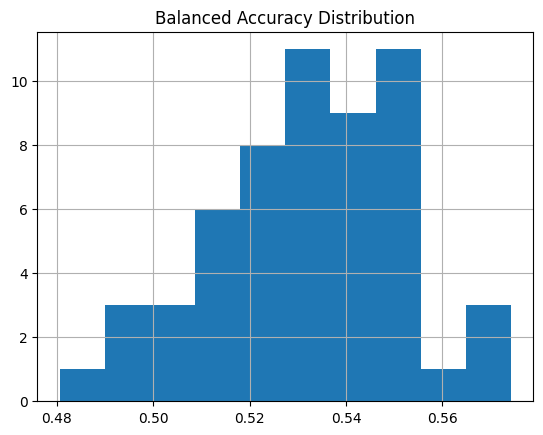

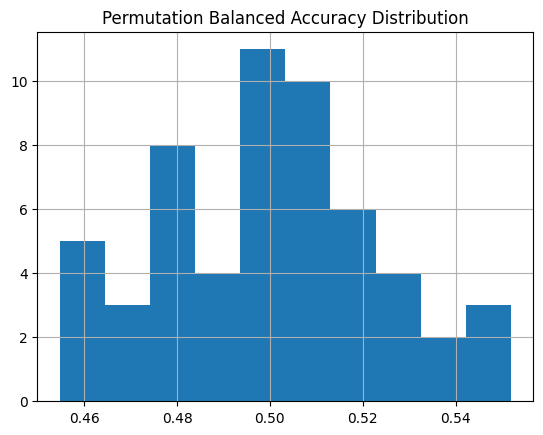

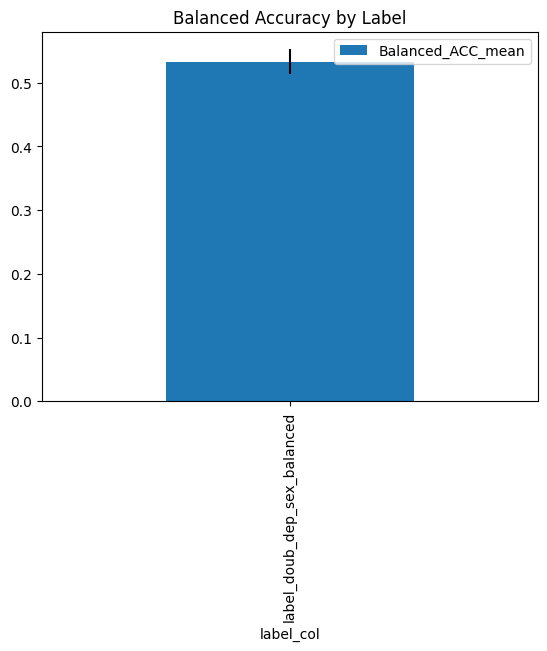

Sorted by mean Depression


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
label_col,,,,,,
label_doub_dep_sex_balanced,0.532863,0.019794,0.574194,0.499777,0.023301,0.551909


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
label_col,,,,,,
label_doub_dep_sex_balanced,0.532863,0.019794,0.574194,0.499777,0.023301,0.551909



Mean and std for Balanced_ACC by mri_table

NOT FILTERED FOR FEATURE EXTRACTION


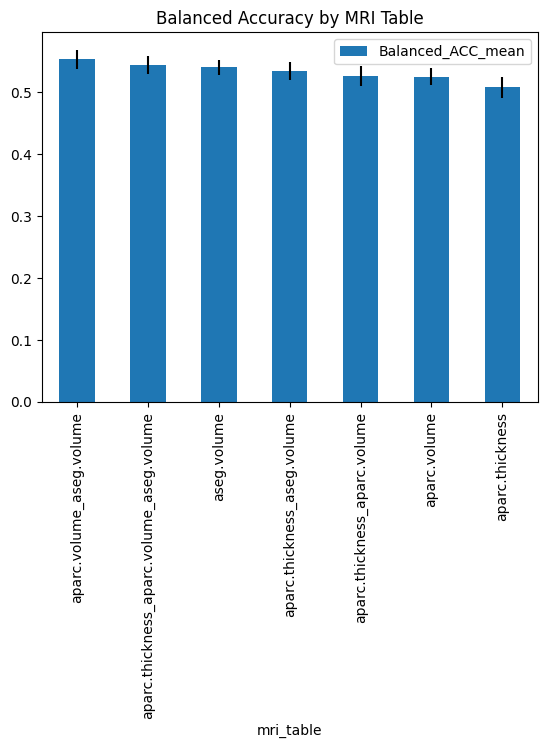

Sorted by mean Depression


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.volume_aseg.volume,0.553024,0.015672,0.574194,0.519753,0.028630,0.551909
aparc.thickness_aparc.volume_aseg.volume,0.544153,0.014527,0.570968,0.484401,0.020075,0.514440
aseg.volume,0.540323,0.012314,0.553226,0.498687,0.029584,0.543104
aparc.thickness_aseg.volume,0.534274,0.014290,0.550000,0.502469,0.018485,0.532983
aparc.thickness_aparc.volume,0.525605,0.016162,0.540323,0.493339,0.017375,0.516743
aparc.volume,0.525000,0.013848,0.551613,0.503267,0.018017,0.525590
aparc.thickness,0.507661,0.016734,0.530645,0.496521,0.019756,0.534520


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.volume_aseg.volume,0.553024,0.015672,0.574194,0.519753,0.028630,0.551909
aparc.thickness_aparc.volume_aseg.volume,0.544153,0.014527,0.570968,0.484401,0.020075,0.514440
aseg.volume,0.540323,0.012314,0.553226,0.498687,0.029584,0.543104
aparc.volume,0.525000,0.013848,0.551613,0.503267,0.018017,0.525590
aparc.thickness_aseg.volume,0.534274,0.014290,0.550000,0.502469,0.018485,0.532983
aparc.thickness_aparc.volume,0.525605,0.016162,0.540323,0.493339,0.017375,0.516743
aparc.thickness,0.507661,0.016734,0.530645,0.496521,0.019756,0.534520


Feature Importance by Count:


features
aparc.volume       4
aseg.volume        4
aparc.thickness    4
Name: count, dtype: int64

FILTERED FOR FEATURE EXTRACTION - NO FEATURE EXTRACTION APPLIED


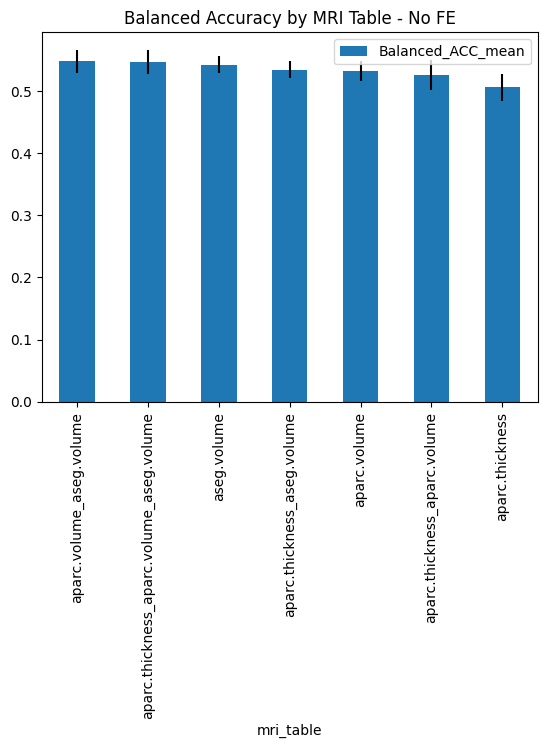

Sorted by mean Depression


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.volume_aseg.volume,0.547581,0.018647,0.567742,0.520167,0.041345,0.551909
aparc.thickness_aparc.volume_aseg.volume,0.545968,0.019555,0.570968,0.474463,0.013761,0.486775
aseg.volume,0.541935,0.013365,0.551613,0.518732,0.020987,0.543104
aparc.thickness_aseg.volume,0.534274,0.013325,0.543548,0.504786,0.024503,0.532983
aparc.volume,0.531855,0.015824,0.551613,0.505572,0.022427,0.525590
aparc.thickness_aparc.volume,0.525403,0.023498,0.540323,0.493533,0.023938,0.516743
aparc.thickness,0.506048,0.021893,0.530645,0.497184,0.027088,0.534520


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.thickness_aparc.volume_aseg.volume,0.545968,0.019555,0.570968,0.474463,0.013761,0.486775
aparc.volume_aseg.volume,0.547581,0.018647,0.567742,0.520167,0.041345,0.551909
aseg.volume,0.541935,0.013365,0.551613,0.518732,0.020987,0.543104
aparc.volume,0.531855,0.015824,0.551613,0.505572,0.022427,0.525590
aparc.thickness_aseg.volume,0.534274,0.013325,0.543548,0.504786,0.024503,0.532983
aparc.thickness_aparc.volume,0.525403,0.023498,0.540323,0.493533,0.023938,0.516743
aparc.thickness,0.506048,0.021893,0.530645,0.497184,0.027088,0.534520


Feature Importance by Count:


features
aparc.volume       4
aseg.volume        4
aparc.thickness    4
Name: count, dtype: int64

Combination counts for features


,count
aparc.volume+aseg.volume,2
aparc.thickness+aparc.volume,2
aparc.thickness+aseg.volume,2
aparc.thickness+aparc.volume+aseg.volume,1


FILTERED FOR FEATURE EXTRACTION - FEATURE EXTRACTION APPLIED
Feature Importance by Count:


features
aparc.volume       4
aseg.volume        4
aparc.thickness    4
Name: count, dtype: int64


Mean and std for Balanced_ACC by model type



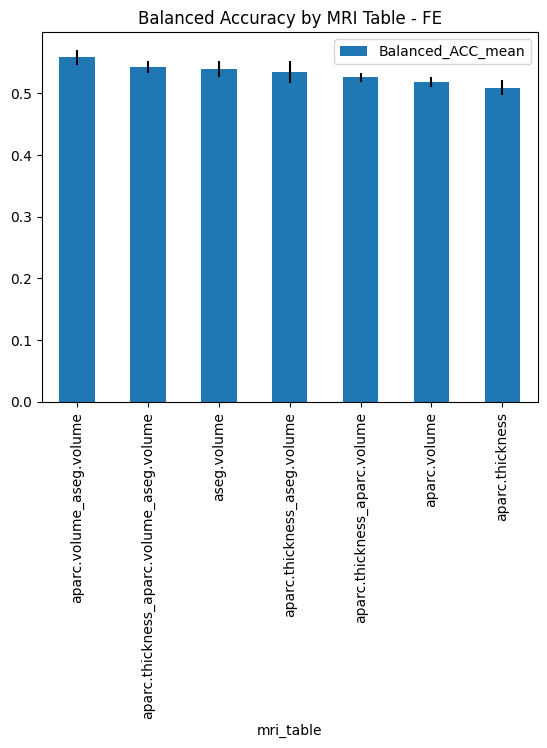

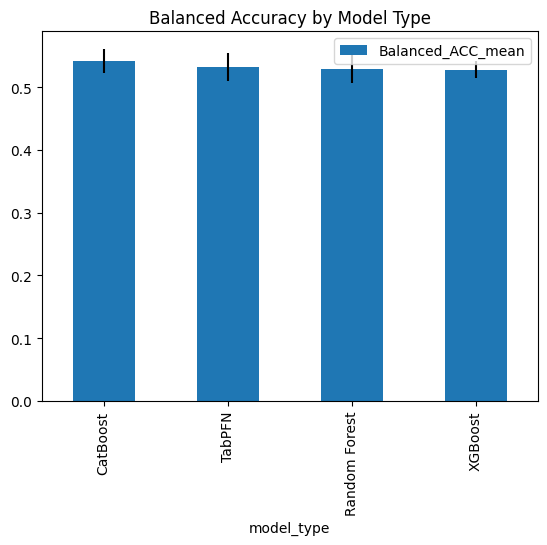

Sorted by mean Depression


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
model_type,,,,,,
CatBoost,0.541590,0.019419,0.570968,0.491284,0.022400,0.532234
TabPFN,0.532604,0.022297,0.559677,0.507671,0.025129,0.551909
Random Forest,0.529032,0.021612,0.574194,0.503065,0.021659,0.532983
XGBoost,0.528226,0.013972,0.550000,0.497087,0.023030,0.545339


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
model_type,,,,,,
Random Forest,0.529032,0.021612,0.574194,0.503065,0.021659,0.532983
CatBoost,0.541590,0.019419,0.570968,0.491284,0.022400,0.532234
TabPFN,0.532604,0.022297,0.559677,0.507671,0.025129,0.551909
XGBoost,0.528226,0.013972,0.550000,0.497087,0.023030,0.545339



Pretraing and Feature Extraction analyses


Pretraining_applied
False    0.532863
Name: Balanced_ACC, dtype: float64

T-test Pretrained vs Non-pretrained: nan nan


/tmp/ipykernel_341309/2396696551.py:48: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_val = ttest_ind(pretrained_data, non_pretrained_data)


Feature_extraction_applied
False    0.533295
True     0.532431
Name: Balanced_ACC, dtype: float64

T-test Feature extraction vs Non-feature extraction: -0.16188342115999627 0.8720018643000036

Pretraining and Finetuning analyses for DL Models



Pretraining_applied
False    0.53414
Name: Balanced_ACC, dtype: float64

T-test Pretrained vs Non-pretrained: nan nan


Feature_extraction_applied
False    0.535868
True     0.532412
Name: Balanced_ACC, dtype: float64

T-test Feature extraction vs Non-feature extraction: -0.576856709981921 0.5672687558981466
------------------------------
------------------------------

Analyses for tag: neurodegernetive
##########
Full analyses
##########

 Sorted by best model



,search_term,model_type,Feature_extraction_applied,Accuracy,AUC,Balanced_ACC,Permutation_Balanced_ACC,cross_validation_count,label_col,mri_table,number_of_pos,number_of_neg,test_set_size,y_label_ratio,sex_label_ratio,Pretraining_applied,tag
83,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,Random Forest,True,0.570833,0.570833,0.570833,0.548020,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aseg.volume,240,239,96,0.5,0.5,False,neurodegernetive
66,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,Random Forest,False,0.568841,0.568841,0.568841,0.479416,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
64,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,CatBoost,False,0.566486,0.566486,0.566486,0.505227,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
70,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,XGBoost,False,0.556250,0.556250,0.556250,0.499957,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
86,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,XGBoost,False,0.555888,0.555888,0.555888,0.475551,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aseg.volume,240,239,96,0.5,0.5,False,neurodegernetive
89,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.v...,CatBoost,True,0.553895,0.553895,0.553895,0.471937,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
75,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,Random Forest,True,0.553533,0.553533,0.553533,0.499027,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aparc.volume_aseg.volume,240,239,96,0.5,0.5,False,neurodegernetive
90,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.v...,Random Forest,False,0.552355,0.552355,0.552355,0.476855,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
88,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.v...,CatBoost,False,0.551630,0.551630,0.551630,0.516860,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
94,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.v...,XGBoost,False,0.550272,0.550272,0.550272,0.496147,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive



Value counts for label column



label_col
label_nd_no_dep_vs_nd_dep_sex_balanced    56
Name: count, dtype: int64


Mean and std for Balanced_ACC



'Overall mean: 0.5319665502070393, std: 0.02074509638622941'

'Overall permuted mean: 0.495439901839826, std: 0.02072192254336101'

'Mean difference: 0.03652664836721331, std difference: 2.3173842868401406e-05'

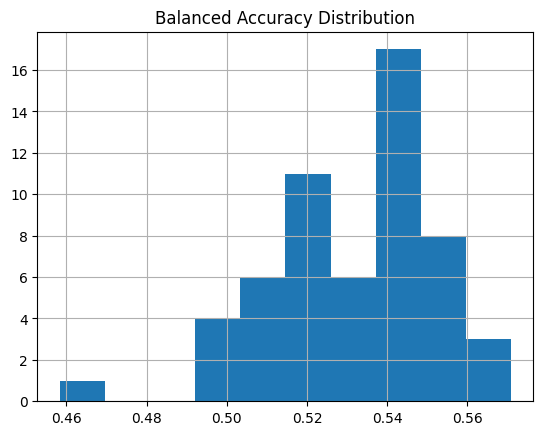

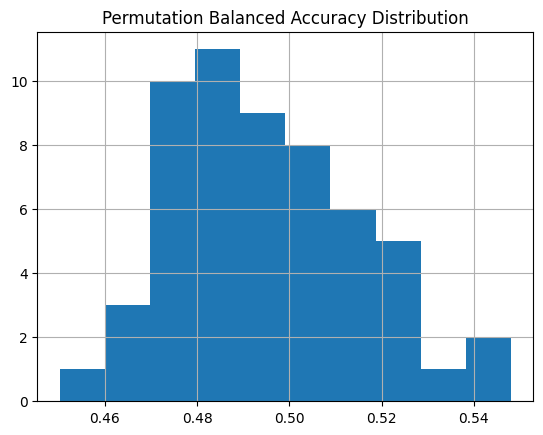

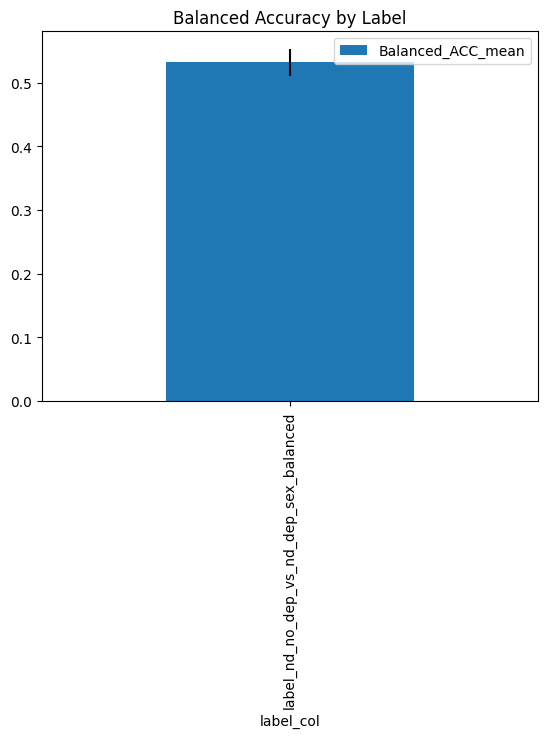

Sorted by mean neurodegernetive


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
label_col,,,,,,
label_nd_no_dep_vs_nd_dep_sex_balanced,0.531967,0.020745,0.570833,0.49544,0.020722,0.54802


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
label_col,,,,,,
label_nd_no_dep_vs_nd_dep_sex_balanced,0.531967,0.020745,0.570833,0.49544,0.020722,0.54802



Mean and std for Balanced_ACC by mri_table

NOT FILTERED FOR FEATURE EXTRACTION


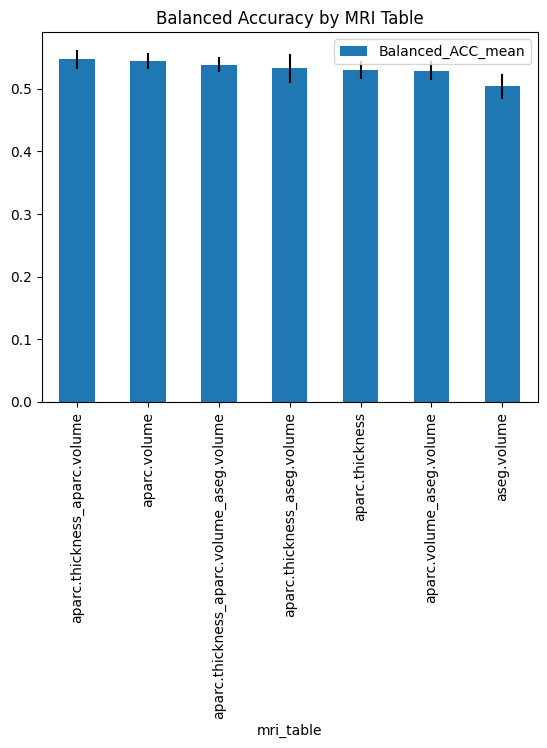

Sorted by mean neurodegernetive


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.thickness_aparc.volume,0.546773,0.015522,0.568841,0.498549,0.016506,0.521802
aparc.volume,0.544611,0.012427,0.553895,0.489047,0.017795,0.516860
aparc.thickness_aparc.volume_aseg.volume,0.538021,0.011913,0.553533,0.499575,0.019011,0.543889
aparc.thickness_aseg.volume,0.532416,0.023658,0.570833,0.503861,0.028346,0.548020
aparc.thickness,0.529337,0.014195,0.543659,0.502907,0.020705,0.529101
aparc.volume_aseg.volume,0.528974,0.015751,0.545652,0.477922,0.016137,0.499557
aseg.volume,0.503635,0.020589,0.524819,0.496218,0.018902,0.521348


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.thickness_aseg.volume,0.532416,0.023658,0.570833,0.503861,0.028346,0.548020
aparc.thickness_aparc.volume,0.546773,0.015522,0.568841,0.498549,0.016506,0.521802
aparc.volume,0.544611,0.012427,0.553895,0.489047,0.017795,0.516860
aparc.thickness_aparc.volume_aseg.volume,0.538021,0.011913,0.553533,0.499575,0.019011,0.543889
aparc.volume_aseg.volume,0.528974,0.015751,0.545652,0.477922,0.016137,0.499557
aparc.thickness,0.529337,0.014195,0.543659,0.502907,0.020705,0.529101
aseg.volume,0.503635,0.020589,0.524819,0.496218,0.018902,0.521348


Feature Importance by Count:


features
aparc.thickness    4
aparc.volume       4
aseg.volume        4
Name: count, dtype: int64

FILTERED FOR FEATURE EXTRACTION - NO FEATURE EXTRACTION APPLIED


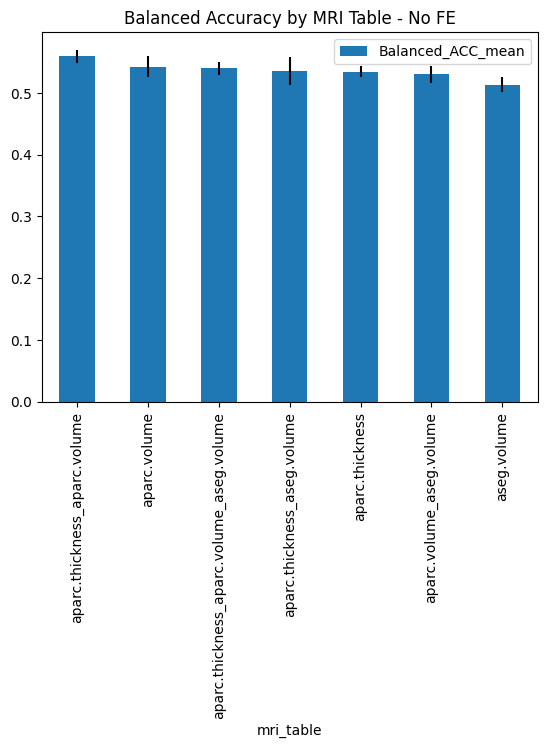

Sorted by mean neurodegernetive


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.thickness_aparc.volume,0.559194,0.010813,0.568841,0.501601,0.017475,0.521802
aparc.volume,0.542640,0.017579,0.552355,0.497913,0.016539,0.516860
aparc.thickness_aparc.volume_aseg.volume,0.539629,0.010554,0.547645,0.504000,0.026972,0.543889
aparc.thickness_aseg.volume,0.535575,0.022473,0.555888,0.493913,0.029907,0.521622
aparc.thickness,0.534715,0.008823,0.543659,0.511275,0.016872,0.529101
aparc.volume_aseg.volume,0.530095,0.014059,0.543841,0.479639,0.016164,0.499557
aseg.volume,0.513247,0.012033,0.524819,0.492427,0.020502,0.521348


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.thickness_aparc.volume,0.559194,0.010813,0.568841,0.501601,0.017475,0.521802
aparc.thickness_aseg.volume,0.535575,0.022473,0.555888,0.493913,0.029907,0.521622
aparc.volume,0.542640,0.017579,0.552355,0.497913,0.016539,0.516860
aparc.thickness_aparc.volume_aseg.volume,0.539629,0.010554,0.547645,0.504000,0.026972,0.543889
aparc.volume_aseg.volume,0.530095,0.014059,0.543841,0.479639,0.016164,0.499557
aparc.thickness,0.534715,0.008823,0.543659,0.511275,0.016872,0.529101
aseg.volume,0.513247,0.012033,0.524819,0.492427,0.020502,0.521348


Feature Importance by Count:


features
aparc.thickness    4
aparc.volume       4
aseg.volume        4
Name: count, dtype: int64

Combination counts for features


,count
aparc.thickness+aparc.volume,2
aparc.thickness+aseg.volume,2
aparc.volume+aseg.volume,2
aparc.thickness+aparc.volume+aseg.volume,1


FILTERED FOR FEATURE EXTRACTION - FEATURE EXTRACTION APPLIED
Feature Importance by Count:


features
aparc.volume       4
aparc.thickness    4
aseg.volume        4
Name: count, dtype: int64


Mean and std for Balanced_ACC by model type



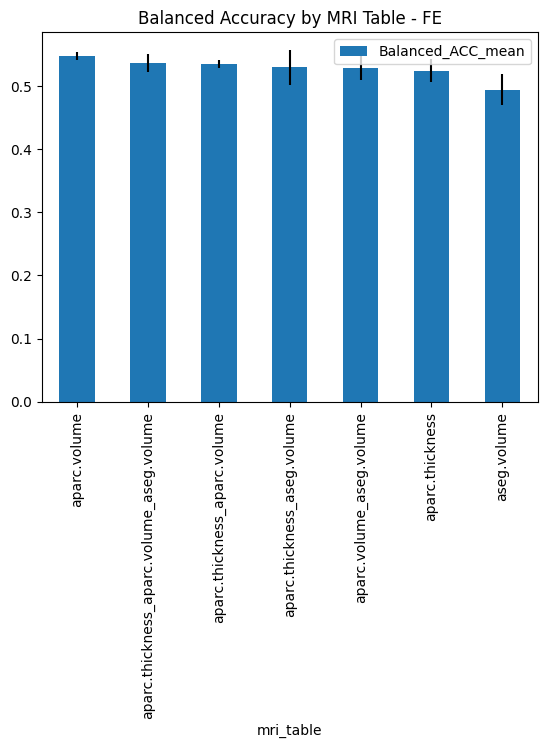

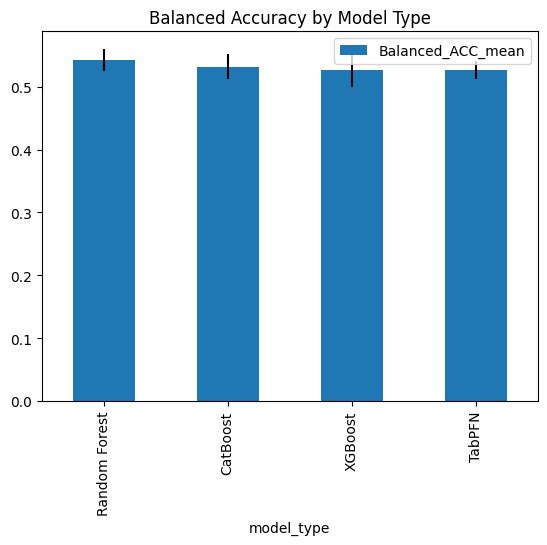

Sorted by mean neurodegernetive


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
model_type,,,,,,
Random Forest,0.542540,0.017523,0.570833,0.493884,0.020501,0.548020
CatBoost,0.531916,0.019754,0.566486,0.502940,0.017700,0.528092
XGBoost,0.527200,0.027274,0.556250,0.488852,0.020516,0.543889
TabPFN,0.526210,0.014110,0.550000,0.496083,0.023492,0.529101


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
model_type,,,,,,
Random Forest,0.542540,0.017523,0.570833,0.493884,0.020501,0.548020
CatBoost,0.531916,0.019754,0.566486,0.502940,0.017700,0.528092
XGBoost,0.527200,0.027274,0.556250,0.488852,0.020516,0.543889
TabPFN,0.526210,0.014110,0.550000,0.496083,0.023492,0.529101



Pretraing and Feature Extraction analyses


Pretraining_applied
False    0.531967
Name: Balanced_ACC, dtype: float64

T-test Pretrained vs Non-pretrained: nan nan


/tmp/ipykernel_341309/2396696551.py:48: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_val = ttest_ind(pretrained_data, non_pretrained_data)


Feature_extraction_applied
False    0.536442
True     0.527491
Name: Balanced_ACC, dtype: float64

T-test Feature extraction vs Non-feature extraction: -1.6390374494415938 0.10701941587546455

Pretraining and Finetuning analyses for DL Models



Pretraining_applied
False    0.528442
Name: Balanced_ACC, dtype: float64

T-test Pretrained vs Non-pretrained: nan nan


Feature_extraction_applied
False    0.533605
True     0.523279
Name: Balanced_ACC, dtype: float64

T-test Feature extraction vs Non-feature extraction: -1.6488911409278721 0.10700317805156764
------------------------------


In [366]:
for tag in df["tag"].unique():
    print("-"*30)
    print(f"\nAnalyses for tag: {tag}")
    df_tag = df[df["tag"] == tag]
    full_analyses(df_tag, show_whole_df_at_start=False, tag=tag)
    print("-"*30)

In [367]:
#just for sex_balanced rows

#df_sexbalanced = df[df["label_col"].str.contains("sex_balanced")]

In [368]:
#drop all the row where in mri_table there is a "Fc" 
#df = df[~df["mri_table"].str.contains("FC")]
#full_analyses(df)

------------------------------

Analyses for tag: Depression
##########
Full analyses
##########

 Sorted by best model



,search_term,model_type,Feature_extraction_applied,Accuracy,AUC,Balanced_ACC,Permutation_Balanced_ACC,cross_validation_count,label_col,mri_table,number_of_pos,number_of_neg,test_set_size,y_label_ratio,sex_label_ratio,Pretraining_applied,tag
43,label_doub_dep_sex_balanced_aparc.volume_aseg....,Random Forest,True,0.574194,0.574194,0.574194,0.503701,2.0,label_doub_dep_sex_balanced,aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
16,label_doub_dep_sex_balanced_aparc.thickness_ap...,CatBoost,False,0.570968,0.570968,0.570968,0.454739,2.0,label_doub_dep_sex_balanced,aparc.thickness_aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
40,label_doub_dep_sex_balanced_aparc.volume_aseg....,CatBoost,False,0.567742,0.567742,0.567742,0.461153,2.0,label_doub_dep_sex_balanced,aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
45,label_doub_dep_sex_balanced_aparc.volume_aseg....,TabPFN,True,0.559677,0.559677,0.559677,0.530553,2.0,label_doub_dep_sex_balanced,aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
41,label_doub_dep_sex_balanced_aparc.volume_aseg....,CatBoost,True,0.554839,0.554839,0.554839,0.532234,2.0,label_doub_dep_sex_balanced,aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
17,label_doub_dep_sex_balanced_aparc.thickness_ap...,CatBoost,True,0.553226,0.553226,0.553226,0.502650,2.0,label_doub_dep_sex_balanced,aparc.thickness_aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
49,label_doub_dep_sex_balanced_aseg.volume.csv,CatBoost,True,0.553226,0.553226,0.553226,0.481005,2.0,label_doub_dep_sex_balanced,aseg.volume,319,316,124,0.5,0.5,False,Depression
48,label_doub_dep_sex_balanced_aseg.volume.csv,CatBoost,False,0.551613,0.551613,0.551613,0.494612,2.0,label_doub_dep_sex_balanced,aseg.volume,319,316,124,0.5,0.5,False,Depression
20,label_doub_dep_sex_balanced_aparc.thickness_ap...,TabPFN,False,0.551613,0.551613,0.551613,0.486775,2.0,label_doub_dep_sex_balanced,aparc.thickness_aparc.volume_aseg.volume,319,316,124,0.5,0.5,False,Depression
36,label_doub_dep_sex_balanced_aparc.volume.csv,TabPFN,False,0.551613,0.551613,0.551613,0.509414,2.0,label_doub_dep_sex_balanced,aparc.volume,319,316,124,0.5,0.5,False,Depression



Value counts for label column



label_col
label_doub_dep_sex_balanced    56
Name: count, dtype: int64


Mean and std for Balanced_ACC



'Overall mean: 0.5328629032258064, std: 0.01979356736073295'

'Overall permuted mean: 0.4997766423884502, std: 0.023300565861837395'

'Mean difference: 0.03308626083735622, std difference: -0.003506998501104447'

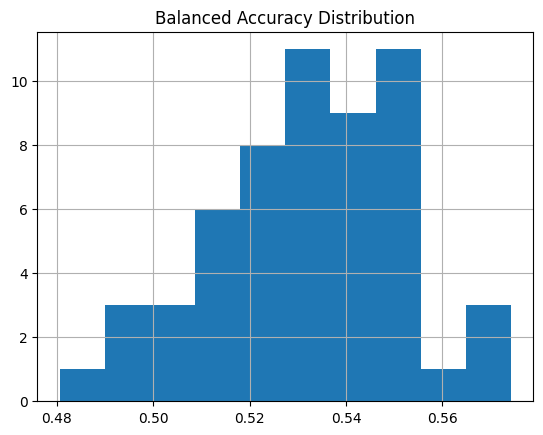

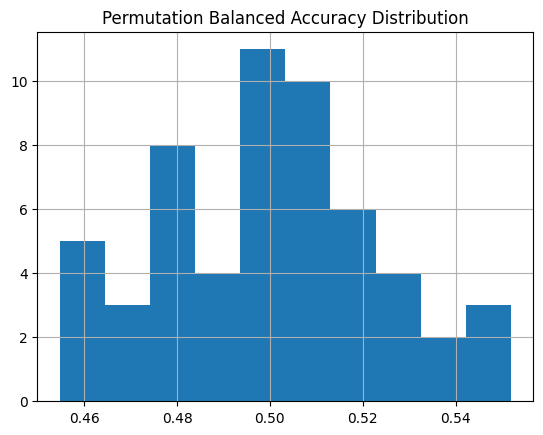

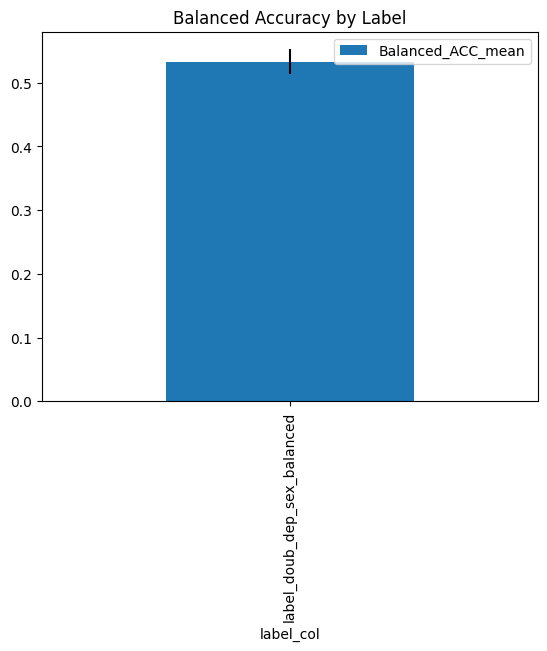

Sorted by mean 


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
label_col,,,,,,
label_doub_dep_sex_balanced,0.532863,0.019794,0.574194,0.499777,0.023301,0.551909


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
label_col,,,,,,
label_doub_dep_sex_balanced,0.532863,0.019794,0.574194,0.499777,0.023301,0.551909



Mean and std for Balanced_ACC by mri_table

NOT FILTERED FOR FEATURE EXTRACTION


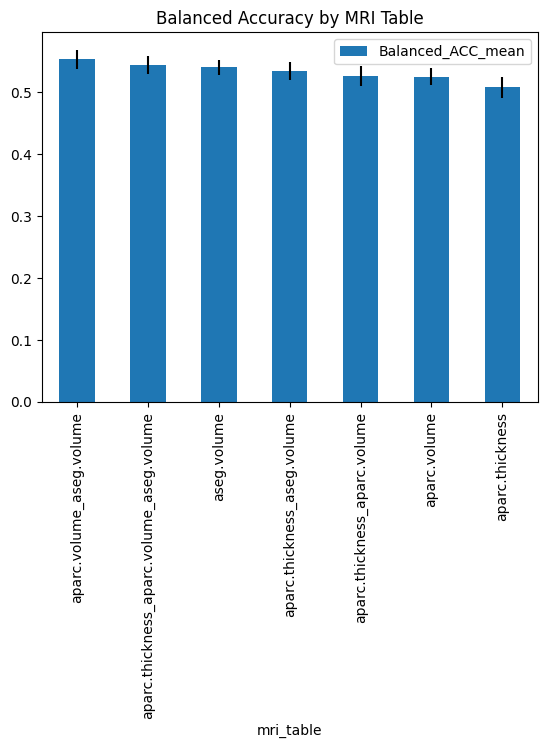

Sorted by mean 


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.volume_aseg.volume,0.553024,0.015672,0.574194,0.519753,0.028630,0.551909
aparc.thickness_aparc.volume_aseg.volume,0.544153,0.014527,0.570968,0.484401,0.020075,0.514440
aseg.volume,0.540323,0.012314,0.553226,0.498687,0.029584,0.543104
aparc.thickness_aseg.volume,0.534274,0.014290,0.550000,0.502469,0.018485,0.532983
aparc.thickness_aparc.volume,0.525605,0.016162,0.540323,0.493339,0.017375,0.516743
aparc.volume,0.525000,0.013848,0.551613,0.503267,0.018017,0.525590
aparc.thickness,0.507661,0.016734,0.530645,0.496521,0.019756,0.534520


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.volume_aseg.volume,0.553024,0.015672,0.574194,0.519753,0.028630,0.551909
aparc.thickness_aparc.volume_aseg.volume,0.544153,0.014527,0.570968,0.484401,0.020075,0.514440
aseg.volume,0.540323,0.012314,0.553226,0.498687,0.029584,0.543104
aparc.volume,0.525000,0.013848,0.551613,0.503267,0.018017,0.525590
aparc.thickness_aseg.volume,0.534274,0.014290,0.550000,0.502469,0.018485,0.532983
aparc.thickness_aparc.volume,0.525605,0.016162,0.540323,0.493339,0.017375,0.516743
aparc.thickness,0.507661,0.016734,0.530645,0.496521,0.019756,0.534520


Feature Importance by Count:


features
aparc.volume       4
aseg.volume        4
aparc.thickness    4
Name: count, dtype: int64

FILTERED FOR FEATURE EXTRACTION - NO FEATURE EXTRACTION APPLIED


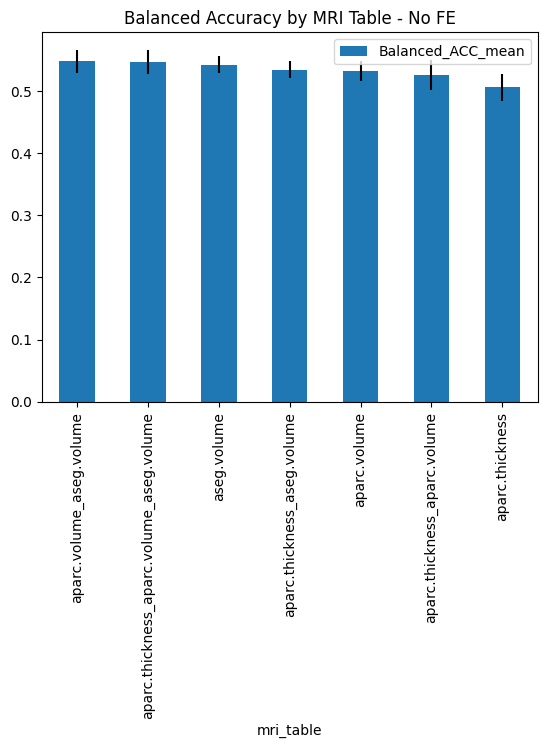

Sorted by mean 


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.volume_aseg.volume,0.547581,0.018647,0.567742,0.520167,0.041345,0.551909
aparc.thickness_aparc.volume_aseg.volume,0.545968,0.019555,0.570968,0.474463,0.013761,0.486775
aseg.volume,0.541935,0.013365,0.551613,0.518732,0.020987,0.543104
aparc.thickness_aseg.volume,0.534274,0.013325,0.543548,0.504786,0.024503,0.532983
aparc.volume,0.531855,0.015824,0.551613,0.505572,0.022427,0.525590
aparc.thickness_aparc.volume,0.525403,0.023498,0.540323,0.493533,0.023938,0.516743
aparc.thickness,0.506048,0.021893,0.530645,0.497184,0.027088,0.534520


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.thickness_aparc.volume_aseg.volume,0.545968,0.019555,0.570968,0.474463,0.013761,0.486775
aparc.volume_aseg.volume,0.547581,0.018647,0.567742,0.520167,0.041345,0.551909
aseg.volume,0.541935,0.013365,0.551613,0.518732,0.020987,0.543104
aparc.volume,0.531855,0.015824,0.551613,0.505572,0.022427,0.525590
aparc.thickness_aseg.volume,0.534274,0.013325,0.543548,0.504786,0.024503,0.532983
aparc.thickness_aparc.volume,0.525403,0.023498,0.540323,0.493533,0.023938,0.516743
aparc.thickness,0.506048,0.021893,0.530645,0.497184,0.027088,0.534520


Feature Importance by Count:


features
aparc.volume       4
aseg.volume        4
aparc.thickness    4
Name: count, dtype: int64

Combination counts for features


,count
aparc.volume+aseg.volume,2
aparc.thickness+aparc.volume,2
aparc.thickness+aseg.volume,2
aparc.thickness+aparc.volume+aseg.volume,1


FILTERED FOR FEATURE EXTRACTION - FEATURE EXTRACTION APPLIED
Feature Importance by Count:


features
aparc.volume       4
aseg.volume        4
aparc.thickness    4
Name: count, dtype: int64


Mean and std for Balanced_ACC by model type



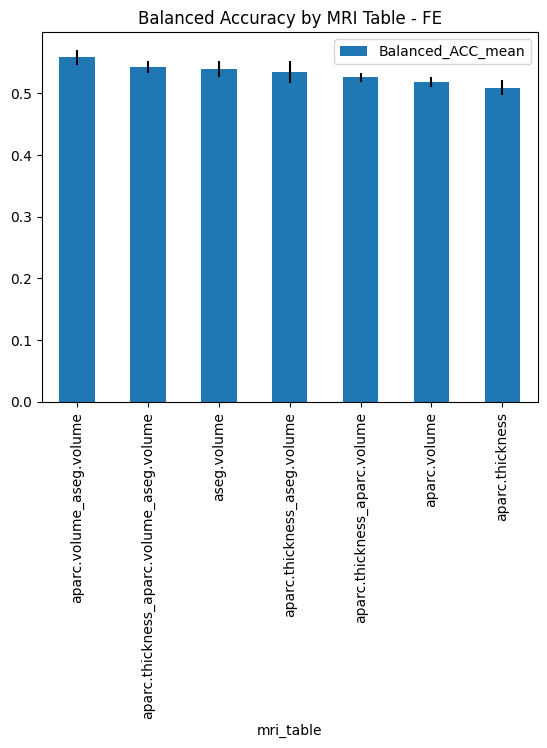

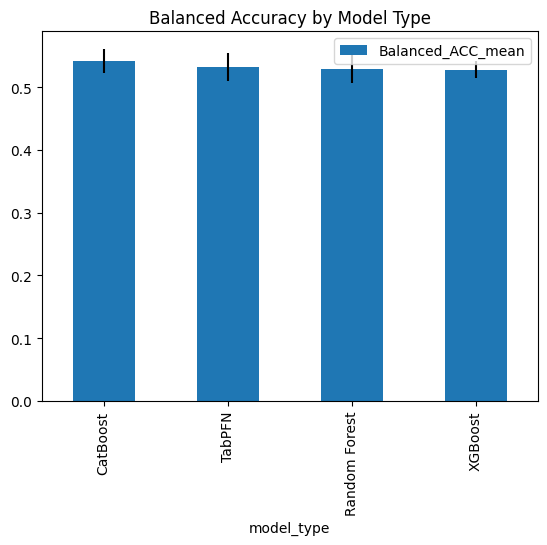

Sorted by mean 


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
model_type,,,,,,
CatBoost,0.541590,0.019419,0.570968,0.491284,0.022400,0.532234
TabPFN,0.532604,0.022297,0.559677,0.507671,0.025129,0.551909
Random Forest,0.529032,0.021612,0.574194,0.503065,0.021659,0.532983
XGBoost,0.528226,0.013972,0.550000,0.497087,0.023030,0.545339


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
model_type,,,,,,
Random Forest,0.529032,0.021612,0.574194,0.503065,0.021659,0.532983
CatBoost,0.541590,0.019419,0.570968,0.491284,0.022400,0.532234
TabPFN,0.532604,0.022297,0.559677,0.507671,0.025129,0.551909
XGBoost,0.528226,0.013972,0.550000,0.497087,0.023030,0.545339



Pretraing and Feature Extraction analyses


Pretraining_applied
False    0.532863
Name: Balanced_ACC, dtype: float64

T-test Pretrained vs Non-pretrained: nan nan


/tmp/ipykernel_341309/2396696551.py:48: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_val = ttest_ind(pretrained_data, non_pretrained_data)


Feature_extraction_applied
False    0.533295
True     0.532431
Name: Balanced_ACC, dtype: float64

T-test Feature extraction vs Non-feature extraction: -0.16188342115999627 0.8720018643000036

Pretraining and Finetuning analyses for DL Models



Pretraining_applied
False    0.53414
Name: Balanced_ACC, dtype: float64

T-test Pretrained vs Non-pretrained: nan nan


Feature_extraction_applied
False    0.535868
True     0.532412
Name: Balanced_ACC, dtype: float64

T-test Feature extraction vs Non-feature extraction: -0.576856709981921 0.5672687558981466
------------------------------
------------------------------

Analyses for tag: neurodegernetive
##########
Full analyses
##########

 Sorted by best model



,search_term,model_type,Feature_extraction_applied,Accuracy,AUC,Balanced_ACC,Permutation_Balanced_ACC,cross_validation_count,label_col,mri_table,number_of_pos,number_of_neg,test_set_size,y_label_ratio,sex_label_ratio,Pretraining_applied,tag
83,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,Random Forest,True,0.570833,0.570833,0.570833,0.548020,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aseg.volume,240,239,96,0.5,0.5,False,neurodegernetive
66,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,Random Forest,False,0.568841,0.568841,0.568841,0.479416,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
64,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,CatBoost,False,0.566486,0.566486,0.566486,0.505227,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
70,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,XGBoost,False,0.556250,0.556250,0.556250,0.499957,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
86,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,XGBoost,False,0.555888,0.555888,0.555888,0.475551,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aseg.volume,240,239,96,0.5,0.5,False,neurodegernetive
89,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.v...,CatBoost,True,0.553895,0.553895,0.553895,0.471937,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
75,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.t...,Random Forest,True,0.553533,0.553533,0.553533,0.499027,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.thickness_aparc.volume_aseg.volume,240,239,96,0.5,0.5,False,neurodegernetive
90,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.v...,Random Forest,False,0.552355,0.552355,0.552355,0.476855,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
88,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.v...,CatBoost,False,0.551630,0.551630,0.551630,0.516860,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive
94,label_nd_no_dep_vs_nd_dep_sex_balanced_aparc.v...,XGBoost,False,0.550272,0.550272,0.550272,0.496147,2.0,label_nd_no_dep_vs_nd_dep_sex_balanced,aparc.volume,240,239,96,0.5,0.5,False,neurodegernetive



Value counts for label column



label_col
label_nd_no_dep_vs_nd_dep_sex_balanced    56
Name: count, dtype: int64


Mean and std for Balanced_ACC



'Overall mean: 0.5319665502070393, std: 0.02074509638622941'

'Overall permuted mean: 0.495439901839826, std: 0.02072192254336101'

'Mean difference: 0.03652664836721331, std difference: 2.3173842868401406e-05'

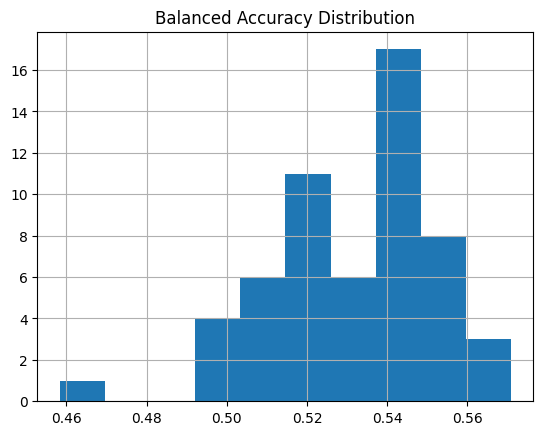

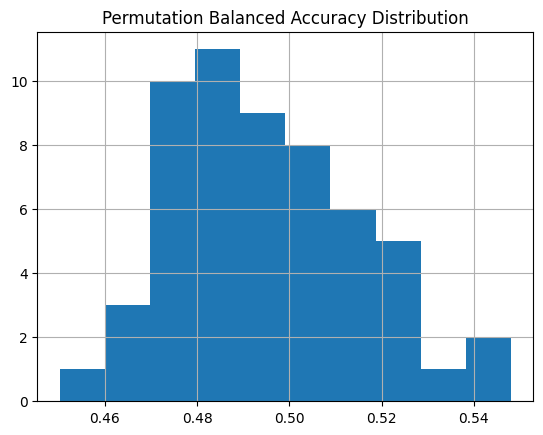

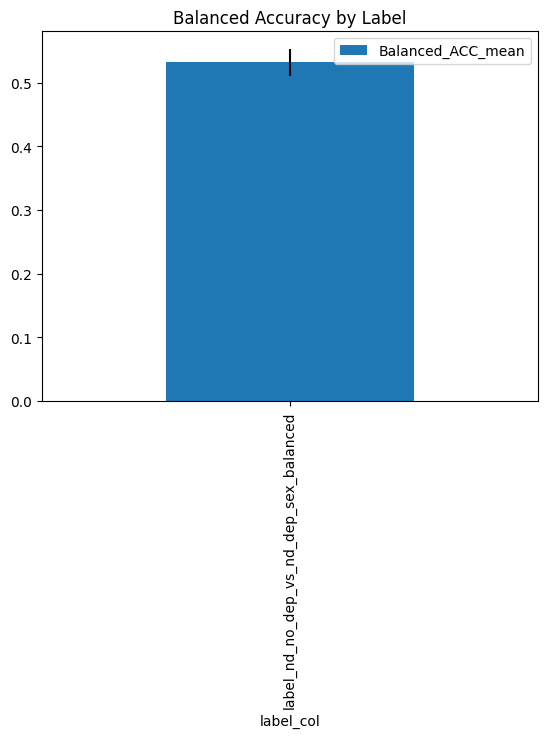

Sorted by mean 


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
label_col,,,,,,
label_nd_no_dep_vs_nd_dep_sex_balanced,0.531967,0.020745,0.570833,0.49544,0.020722,0.54802


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
label_col,,,,,,
label_nd_no_dep_vs_nd_dep_sex_balanced,0.531967,0.020745,0.570833,0.49544,0.020722,0.54802



Mean and std for Balanced_ACC by mri_table

NOT FILTERED FOR FEATURE EXTRACTION


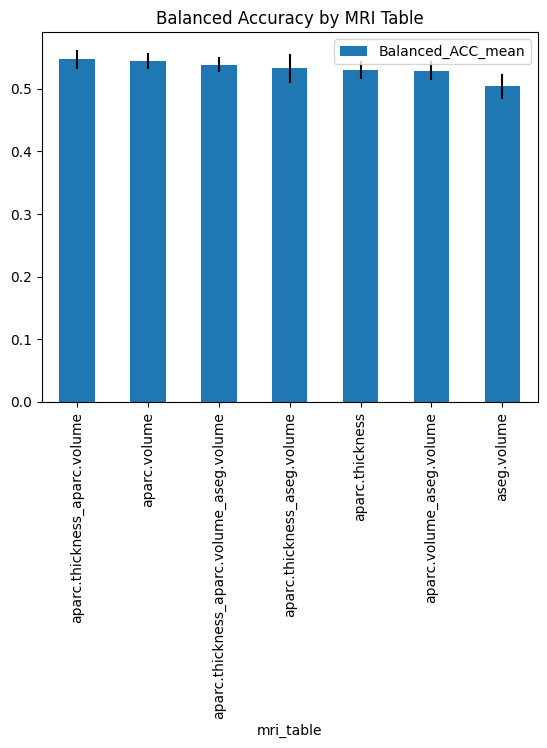

Sorted by mean 


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.thickness_aparc.volume,0.546773,0.015522,0.568841,0.498549,0.016506,0.521802
aparc.volume,0.544611,0.012427,0.553895,0.489047,0.017795,0.516860
aparc.thickness_aparc.volume_aseg.volume,0.538021,0.011913,0.553533,0.499575,0.019011,0.543889
aparc.thickness_aseg.volume,0.532416,0.023658,0.570833,0.503861,0.028346,0.548020
aparc.thickness,0.529337,0.014195,0.543659,0.502907,0.020705,0.529101
aparc.volume_aseg.volume,0.528974,0.015751,0.545652,0.477922,0.016137,0.499557
aseg.volume,0.503635,0.020589,0.524819,0.496218,0.018902,0.521348


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.thickness_aseg.volume,0.532416,0.023658,0.570833,0.503861,0.028346,0.548020
aparc.thickness_aparc.volume,0.546773,0.015522,0.568841,0.498549,0.016506,0.521802
aparc.volume,0.544611,0.012427,0.553895,0.489047,0.017795,0.516860
aparc.thickness_aparc.volume_aseg.volume,0.538021,0.011913,0.553533,0.499575,0.019011,0.543889
aparc.volume_aseg.volume,0.528974,0.015751,0.545652,0.477922,0.016137,0.499557
aparc.thickness,0.529337,0.014195,0.543659,0.502907,0.020705,0.529101
aseg.volume,0.503635,0.020589,0.524819,0.496218,0.018902,0.521348


Feature Importance by Count:


features
aparc.thickness    4
aparc.volume       4
aseg.volume        4
Name: count, dtype: int64

FILTERED FOR FEATURE EXTRACTION - NO FEATURE EXTRACTION APPLIED


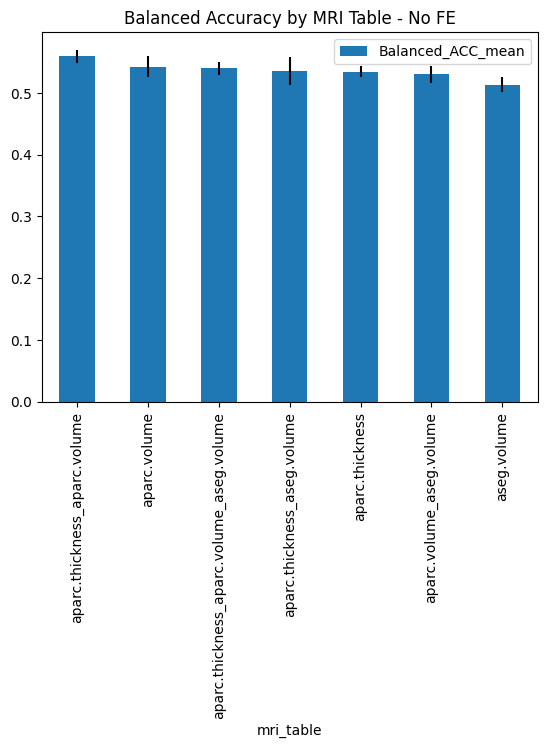

Sorted by mean 


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.thickness_aparc.volume,0.559194,0.010813,0.568841,0.501601,0.017475,0.521802
aparc.volume,0.542640,0.017579,0.552355,0.497913,0.016539,0.516860
aparc.thickness_aparc.volume_aseg.volume,0.539629,0.010554,0.547645,0.504000,0.026972,0.543889
aparc.thickness_aseg.volume,0.535575,0.022473,0.555888,0.493913,0.029907,0.521622
aparc.thickness,0.534715,0.008823,0.543659,0.511275,0.016872,0.529101
aparc.volume_aseg.volume,0.530095,0.014059,0.543841,0.479639,0.016164,0.499557
aseg.volume,0.513247,0.012033,0.524819,0.492427,0.020502,0.521348


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
mri_table,,,,,,
aparc.thickness_aparc.volume,0.559194,0.010813,0.568841,0.501601,0.017475,0.521802
aparc.thickness_aseg.volume,0.535575,0.022473,0.555888,0.493913,0.029907,0.521622
aparc.volume,0.542640,0.017579,0.552355,0.497913,0.016539,0.516860
aparc.thickness_aparc.volume_aseg.volume,0.539629,0.010554,0.547645,0.504000,0.026972,0.543889
aparc.volume_aseg.volume,0.530095,0.014059,0.543841,0.479639,0.016164,0.499557
aparc.thickness,0.534715,0.008823,0.543659,0.511275,0.016872,0.529101
aseg.volume,0.513247,0.012033,0.524819,0.492427,0.020502,0.521348


Feature Importance by Count:


features
aparc.thickness    4
aparc.volume       4
aseg.volume        4
Name: count, dtype: int64

Combination counts for features


,count
aparc.thickness+aparc.volume,2
aparc.thickness+aseg.volume,2
aparc.volume+aseg.volume,2
aparc.thickness+aparc.volume+aseg.volume,1


FILTERED FOR FEATURE EXTRACTION - FEATURE EXTRACTION APPLIED
Feature Importance by Count:


features
aparc.volume       4
aparc.thickness    4
aseg.volume        4
Name: count, dtype: int64


Mean and std for Balanced_ACC by model type



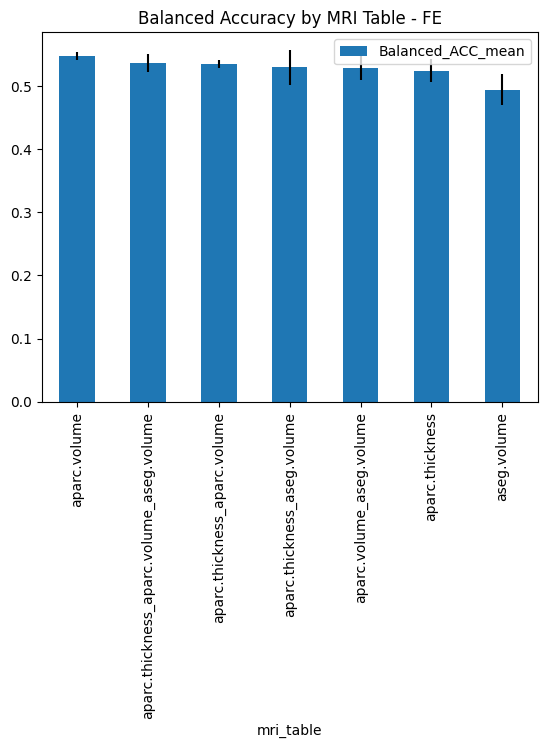

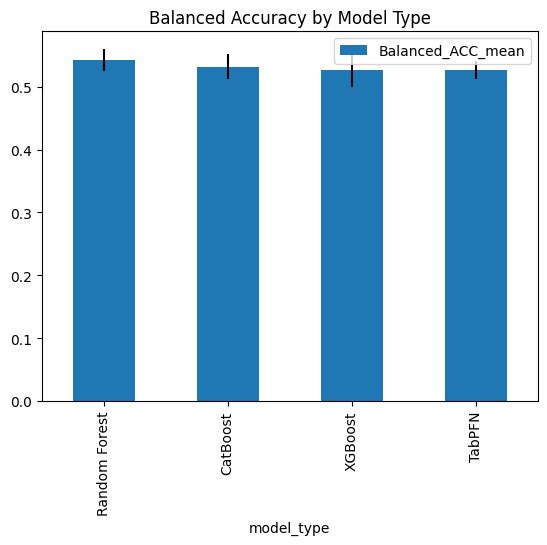

Sorted by mean 


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
model_type,,,,,,
Random Forest,0.542540,0.017523,0.570833,0.493884,0.020501,0.548020
CatBoost,0.531916,0.019754,0.566486,0.502940,0.017700,0.528092
XGBoost,0.527200,0.027274,0.556250,0.488852,0.020516,0.543889
TabPFN,0.526210,0.014110,0.550000,0.496083,0.023492,0.529101


Sorted by max


,Balanced_ACC_mean,Balanced_ACC_std,Balanced_ACC_max,Permutation_Balanced_ACC_mean,Permutation_Balanced_ACC_std,Permutation_Balanced_ACC_max
model_type,,,,,,
Random Forest,0.542540,0.017523,0.570833,0.493884,0.020501,0.548020
CatBoost,0.531916,0.019754,0.566486,0.502940,0.017700,0.528092
XGBoost,0.527200,0.027274,0.556250,0.488852,0.020516,0.543889
TabPFN,0.526210,0.014110,0.550000,0.496083,0.023492,0.529101



Pretraing and Feature Extraction analyses


Pretraining_applied
False    0.531967
Name: Balanced_ACC, dtype: float64

T-test Pretrained vs Non-pretrained: nan nan


/tmp/ipykernel_341309/2396696551.py:48: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_val = ttest_ind(pretrained_data, non_pretrained_data)


Feature_extraction_applied
False    0.536442
True     0.527491
Name: Balanced_ACC, dtype: float64

T-test Feature extraction vs Non-feature extraction: -1.6390374494415938 0.10701941587546455

Pretraining and Finetuning analyses for DL Models



Pretraining_applied
False    0.528442
Name: Balanced_ACC, dtype: float64

T-test Pretrained vs Non-pretrained: nan nan


Feature_extraction_applied
False    0.533605
True     0.523279
Name: Balanced_ACC, dtype: float64

T-test Feature extraction vs Non-feature extraction: -1.6488911409278721 0.10700317805156764
------------------------------


In [369]:
for tag in df["tag"].unique():
    print("-"*30)
    print(f"\nAnalyses for tag: {tag}")
    df_tag = df[df["tag"] == tag]
    full_analyses(df_tag)
    print("-"*30)